# Network Science project

# Twitch Social Network - Germany

Lisanna Lehes, Siim Suitslepp

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
edges = pd.read_csv('musae_DE_edges.csv')
nodes = pd.read_csv('musae_DE_target.csv')

In [3]:
print('Nodes dataset dimension:', nodes.shape, '\nEdges dataset dimension:', edges.shape)

Nodes dataset dimension: (9498, 6) 
Edges dataset dimension: (153138, 2)


## 1. Exploring the data - Descriptive Analysis

In [203]:
nodes.head()

id  days  mature   views  partner  new_id
0   37905227  2149    True  162078    False    5079
1   63102384  1574    True    1370    False    4281
2  109414094  1034    True    6043    False     992
3   84163849  1319    True   94298     True    9021
4   38240837  2137    True    2323    False     330

In [204]:
edges.head()

from    to
0     0  9206
1     0  7787
2     0  2145
3     0  2684
4     0  7275

In [205]:
edges.describe()

from             to
count  153138.000000  153138.000000
mean     3672.458103    6060.992510
std      2511.565127    2437.219301
min         0.000000       5.000000
25%      1613.000000    4150.000000
50%      3173.000000    6619.000000
75%      5519.000000    8080.000000
max      9488.000000    9497.000000

We can see from here that it uses new_id instead of id so we will drop id collumn and only use new_id

### Dropping unnessesary columns

In [4]:
nodes.drop("id", axis=1, inplace=True)

In [5]:
nodes.rename(columns = {'new_id':'id'}, inplace = True)

In [6]:
nodes.head()

days  mature   views  partner    id
0  2149    True  162078    False  5079
1  1574    True    1370    False  4281
2  1034    True    6043    False   992
3  1319    True   94298     True  9021
4  2137    True    2323    False   330

### Checking for null values

In [209]:
nodes.isnull().sum()

days       0
mature     0
views      0
partner    0
id         0
dtype: int64

In [210]:
edges.isnull().sum()

from    0
to      0
dtype: int64

There are no NAN values in dataset

### Checking data types

In [211]:
nodes.dtypes

days       int64
mature      bool
views      int64
partner     bool
id         int64
dtype: object

In [7]:
#correcting datatypes

nodes.mature = nodes.mature.astype(int) 
nodes.partner = nodes.partner.astype(int)

In [8]:
nodes.dtypes

days       int64
mature     int32
views      int64
partner    int32
id         int64
dtype: object

### Visualizing

Text(0, 0.5, 'Views on Twitch')

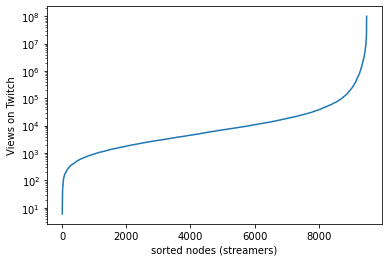

In [214]:
nodes_views = nodes.sort_values(by = ['views'])
views = nodes_views['views']
views = views.reset_index()
plt.plot(views['views'])
plt.yscale("log")
plt.title("")
plt.xlabel("sorted nodes (streamers)")
plt.ylabel("Views on Twitch")

Text(0, 0.5, 'Days on Twitch')

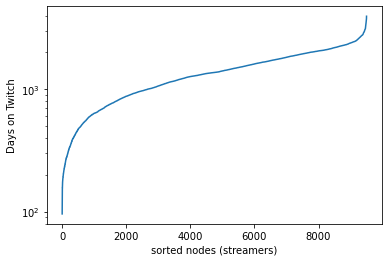

In [215]:
nodes_days = nodes.sort_values(by = ['days'])
days = nodes_days['days']
days = days.reset_index()
plt.plot(days['days'])
plt.yscale("log")
plt.xlabel("sorted nodes (streamers)")
plt.ylabel("Days on Twitch")

In [9]:
nodes.set_index('id')

days  mature     views  partner
id                                   
5079  2149       1    162078        0
4281  1574       1      1370        0
992   1034       1      6043        0
9021  1319       1     94298        1
330   2137       1      2323        0
...    ...     ...       ...      ...
4572   895       1       128        0
6355  2001       0        44        0
206   1784       1      2038        0
7695  2114       0       449        0
4451  1680       0  10638954        1

[9498 rows x 4 columns]

## 2. Graph analysis

In [217]:
nodes_dict = nodes.to_dict('index')

In [218]:
# creating the graph

G_unweighted_undirected = nx.from_pandas_edgelist(edges, source='from', target='to')
nx.set_node_attributes(G_unweighted_undirected, nodes_dict)

In [219]:
# Edge density
nx.classes.function.density(G_unweighted_undirected) 

0.0033954267301620203

In [220]:
# Transitivity
nx.transitivity(G_unweighted_undirected)

0.0464708891573653

In [221]:
# Average shortest path length
nx.average_shortest_path_length(G_unweighted_undirected) 

KeyboardInterrupt: 

In [ ]:
# Clustering coefficient
nx.average_clustering(G_unweighted_undirected) 

In [ ]:
# Diameter of the graph 
nx.diameter(G_unweighted_undirected) 

In [ ]:
# Betweenness centrality
#nx.betweenness_centrality(G_unweighted_undirected) 

# 3. Attribute analysis 

In [ ]:
# Calculating Correlation

corr = nodes[['days','mature','views','partner']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
p = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
p.set(title = "Correlation heatmap")

## 4. Model building - classification tasks

## GraphSAGE

GraphSAGE is an inductive framework that leverages node attribute information to efficiently generate representations on previously unseen data. Hence, it is a framework for inductive representation learning on large graphs. It is used to generate low-dimensional vector representations for nodes, and is especially useful for graphs that have rich node attribute information.

In [10]:
!pip install stellargraph
import itertools
import os

from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
print("Version:", sg.version.__version__)

Version: 1.2.1


### 1. Data preparation

In [12]:
edges.head()

from    to
0     0  9206
1     0  7787
2     0  2145
3     0  2684
4     0  7275

In [13]:
nodes.head()

days  mature   views  partner    id
0  2149       1  162078        0  5079
1  1574       1    1370        0  4281
2  1034       1    6043        0   992
3  1319       1   94298        1  9021
4  2137       1    2323        0   330

In [14]:
# Renaming 'from' and 'to' columns
edges.rename(columns = {'from':'source', 'to':'target'}, inplace = True)
edges.head()

source  target
0       0    9206
1       0    7787
2       0    2145
3       0    2684
4       0    7275

In [15]:
# Replacing the current index by moving the 'id' column to it
nodes2 = nodes.set_index('id')
nodes2

days  mature     views  partner
id                                   
5079  2149       1    162078        0
4281  1574       1      1370        0
992   1034       1      6043        0
9021  1319       1     94298        1
330   2137       1      2323        0
...    ...     ...       ...      ...
4572   895       1       128        0
6355  2001       0        44        0
206   1784       1      2038        0
7695  2114       0       449        0
4451  1680       0  10638954        1

[9498 rows x 4 columns]

In [17]:
# Dropping the 'label' column
nodes_no_partner = nodes2.drop(columns="partner")
nodes_no_partner

days  mature     views
id                          
5079  2149       1    162078
4281  1574       1      1370
992   1034       1      6043
9021  1319       1     94298
330   2137       1      2323
...    ...     ...       ...
4572   895       1       128
6355  2001       0        44
206   1784       1      2038
7695  2114       0       449
4451  1680       0  10638954

[9498 rows x 3 columns]

In order to use methods like GraphSAGE and GCN, which operate on a single graph, we must construct a single instance of the StellarGraph class.  
See [here](https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-pandas.html).

In [18]:
twitch_graph = StellarGraph(nodes_no_partner, edges)
print(twitch_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 9498, Edges: 153138

 Node types:
  default: [9498]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [153138]
        Weights: all 1 (default)
        Features: none


We’ll  need to use the 'partner' labels as ground-truth labels. This can be extracted from the DataFrame and held separately, to be passed in as training, validation or test examples.

In [19]:
twitch_partner = nodes2["partner"]
twitch_partner

id
5079    0
4281    0
992     0
9021    1
330     0
       ..
4572    0
6355    0
206     0
7695    0
4451    1
Name: partner, Length: 9498, dtype: int32

In [20]:
set(twitch_partner)

{0, 1}

In [21]:
twitch_partner.value_counts()

# Class imbalance could be a problem

0    8901
1     597
Name: partner, dtype: int64

In [22]:
len(twitch_partner)

9498

### 2. Splitting the data

Removing 20% of the nodes from the graph. Then, we are going to train a GraphSAGE model on the reduced graph with the remaining 80% of the nodes from the original graph. Later, we are going to re-introduce the removed nodes and try to predict their labels without re-training the GraphSAGE model.

In [23]:
labels_sampled = twitch_partner.sample(frac=0.8, replace=False, random_state=101)
labels_sampled
print('Length of sampled labels: ', labels_sampled)

Length of sampled labels:  id
5147    0
4829    0
2763    0
8989    0
1381    0
       ..
4756    0
4725    0
9321    0
5662    0
4618    0
Name: partner, Length: 7598, dtype: int32


In [24]:
# Extracting the subgraph corresponding to the sampled nodes
graph_sampled = twitch_graph.subgraph(labels_sampled.index)
print(graph_sampled.info())

StellarGraph: Undirected multigraph
 Nodes: 7598, Edges: 98828

 Node types:
  default: [7598]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [98828]
        Weights: all 1 (default)
        Features: none


Using scikit-learn to subset the nodes for test and train.

In [25]:
train_labels, test_labels = model_selection.train_test_split(
    labels_sampled,
    train_size=0.05,
    test_size=None,
    stratify=labels_sampled,
    random_state=42,
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=0.2, test_size=None, stratify=test_labels, random_state=100,
)

In [26]:
from collections import Counter

Counter(test_labels)

Counter({0: 5431, 1: 345})

In [27]:
train_targets = train_labels
val_targets = val_labels
test_targets = test_labels

In [28]:
len(train_targets)

379

### 3. Creating the model in Keras

In [29]:
batch_size = 50
num_samples = [10, 10]

In [30]:
# A GraphSAGENodeGenerator object 
generator = GraphSAGENodeGenerator(graph_sampled, batch_size, num_samples) # for node classification and related tasks

Using the generator.flow() method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The shuffle=True argument is given to the flow method to improve training.

In [31]:
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)

Now we can start with our ML model. A few more parameters:

1. The layer_sizes is a list of hidden feature sizes of each layer in the model. We use 32-dimensional hidden node features at each layer

2. The bias and dropout are internal parameters of the model

In [32]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout = 0.2 # without dropout/less than 0.5 performs better
)

In [33]:
# Creating a model to predict the 2 categories using Keras sigmoid layers
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=1, activation="sigmoid")(x_out) 

# Sigmoid activation function is used for binary class classification


In [34]:
np.unique(train_targets)

array([0, 1])

In [35]:
train_targets.shape[0] 

379

In [36]:
prediction.shape

TensorShape([None, 1])

### 4. Training and evaluating

Creating the Keras model with the graph inputs x_inp provided by the graph_model and outputs being the predictions from the sigmoid layer

In [37]:
#getting f1 score

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [38]:
model = Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer = optimizers.Adam(lr=0.005), 
    loss = losses.binary_crossentropy,
    metrics = ['acc',f1_m,precision_m, recall_m]
)

# For binary classification problems --> binary_crossentropy is usually the choice for loss function
# mean_squared_error may also be used

C:\Users\lisannal\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 10, 3)     0           ['input_2[0][0]']                
                                                                                              

Now, training the model and keeping track of its loss and accuracy on the training set, and its generalisation performanse on the validation set.

In [40]:
# Validation data generator
val_gen = generator.flow(val_labels.index, val_targets)

In [41]:
# Dealing with class imbalance
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(val_targets),
                                            y=val_targets)
weights = {i:w for i,w in enumerate(weights)}

In [42]:
weights

{0: 0.5316875460574797, 1: 8.38953488372093}

In [43]:
history = model.fit(
    train_gen, epochs=60, validation_data=val_gen, verbose=1, shuffle=False, class_weight=weights
)

Epoch 1/60
8/8 [==============================] - 3s 184ms/step - loss: 0.6248 - acc: 0.6332 - f1_m: 0.2120 - precision_m: 0.1310 - recall_m: 0.7042 - val_loss: 0.5833 - val_acc: 0.6930 - val_f1_m: 0.2058 - val_precision_m: 0.1255 - val_recall_m: 0.7216
Epoch 2/60
8/8 [==============================] - 1s 121ms/step - loss: 0.6022 - acc: 0.6728 - f1_m: 0.2220 - precision_m: 0.1333 - recall_m: 0.7583 - val_loss: 0.5569 - val_acc: 0.6902 - val_f1_m: 0.2135 - val_precision_m: 0.1300 - val_recall_m: 0.7293
Epoch 3/60
8/8 [==============================] - 1s 119ms/step - loss: 0.5899 - acc: 0.6412 - f1_m: 0.1756 - precision_m: 0.1058 - recall_m: 0.6562 - val_loss: 0.5533 - val_acc: 0.6875 - val_f1_m: 0.2102 - val_precision_m: 0.1272 - val_recall_m: 0.7365
Epoch 4/60
8/8 [==============================] - 1s 123ms/step - loss: 0.6079 - acc: 0.6464 - f1_m: 0.1970 - precision_m: 0.1265 - recall_m: 0.6729 - val_loss: 0.5391 - val_acc: 0.6979 - val_f1_m: 0.2328 - val_precision_m: 0.1428 - val_r

8/8 [==============================] - 1s 118ms/step - loss: 0.3556 - acc: 0.8839 - f1_m: 0.4101 - precision_m: 0.3018 - recall_m: 0.7208 - val_loss: 0.2874 - val_acc: 0.9106 - val_f1_m: 0.5036 - val_precision_m: 0.3703 - val_recall_m: 0.8770
Epoch 34/60
8/8 [==============================] - 1s 119ms/step - loss: 0.3238 - acc: 0.8997 - f1_m: 0.5118 - precision_m: 0.4001 - recall_m: 0.7875 - val_loss: 0.2805 - val_acc: 0.9113 - val_f1_m: 0.5065 - val_precision_m: 0.3833 - val_recall_m: 0.8529
Epoch 35/60
8/8 [==============================] - 1s 116ms/step - loss: 0.3407 - acc: 0.8971 - f1_m: 0.4148 - precision_m: 0.3035 - recall_m: 0.7458 - val_loss: 0.2742 - val_acc: 0.9196 - val_f1_m: 0.5463 - val_precision_m: 0.4380 - val_recall_m: 0.8443
Epoch 36/60
8/8 [==============================] - 1s 114ms/step - loss: 0.3057 - acc: 0.9235 - f1_m: 0.4919 - precision_m: 0.3728 - recall_m: 0.7396 - val_loss: 0.2748 - val_acc: 0.9113 - val_f1_m: 0.4973 - val_precision_m: 0.3826 - val_recall_m:

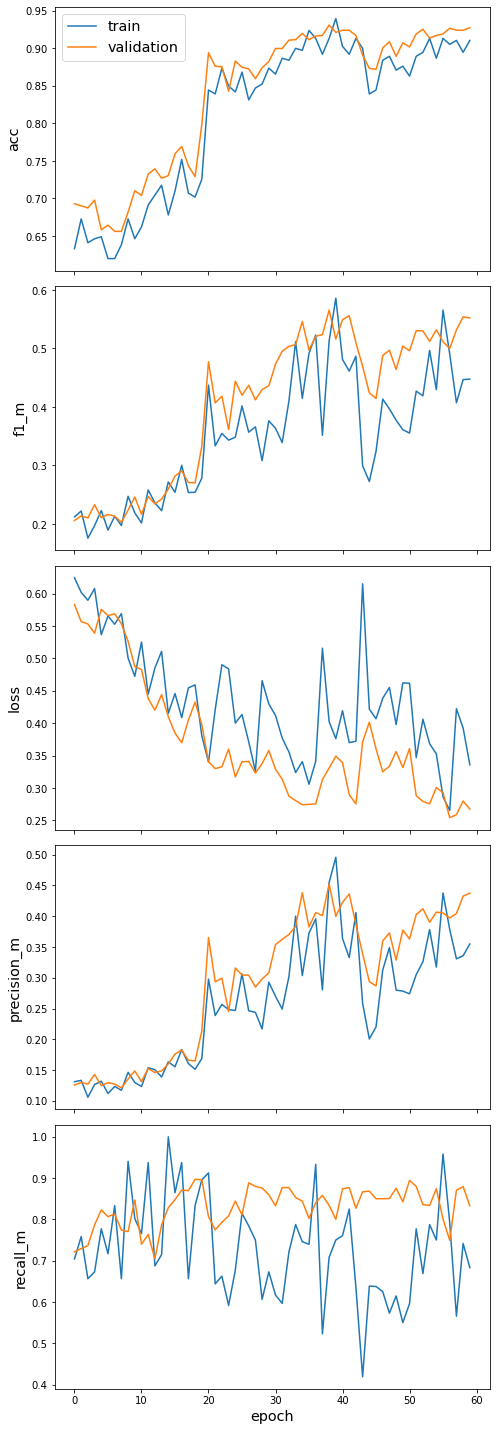

In [44]:
sg.utils.plot_history(history)

In [45]:
# Evaluating on the test set
test_gen = generator.flow(test_labels.index, test_targets)

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

116/116 [==============================] - 3s 23ms/step - loss: 0.2750 - acc: 0.9245 - f1_m: 0.5614 - precision_m: 0.4337 - recall_m: 0.8887

Test Set Metrics:
	loss: 0.2750
	acc: 0.9245
	f1_m: 0.5614
	precision_m: 0.4337
	recall_m: 0.8887


Adam optimizer is the best choice in general. Anyway, many recent papers state that SGD (Stochastic Gradient Descent) can bring to better results if combined with a good learning rate annealing schedule which aims to manage its value during the training. See [here](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e).

In [257]:
graphsage_model2 = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5
)

In [258]:
# Creating a model to predict the 2 categories using Keras sigmoid layers
x_inp2, x_out2 = graphsage_model2.in_out_tensors()
prediction2 = layers.Dense(units=1, activation="sigmoid")(x_out2) 


In [259]:
model2 = Model(inputs=x_inp2, outputs=prediction2)

model2.compile(
    optimizer = optimizers.SGD(lr=0.005), 
    loss = losses.binary_crossentropy,
    metrics = ['acc',f1_m,precision_m, recall_m]
)

C:\Users\lisannal\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [260]:
model2.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 10, 3)]      0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 100, 3)]     0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 1, 3)]       0           []                               
                                                                                                  
 reshape_48 (Reshape)           (None, 1, 10, 3)     0           ['input_38[0][0]']               
                                                                                           

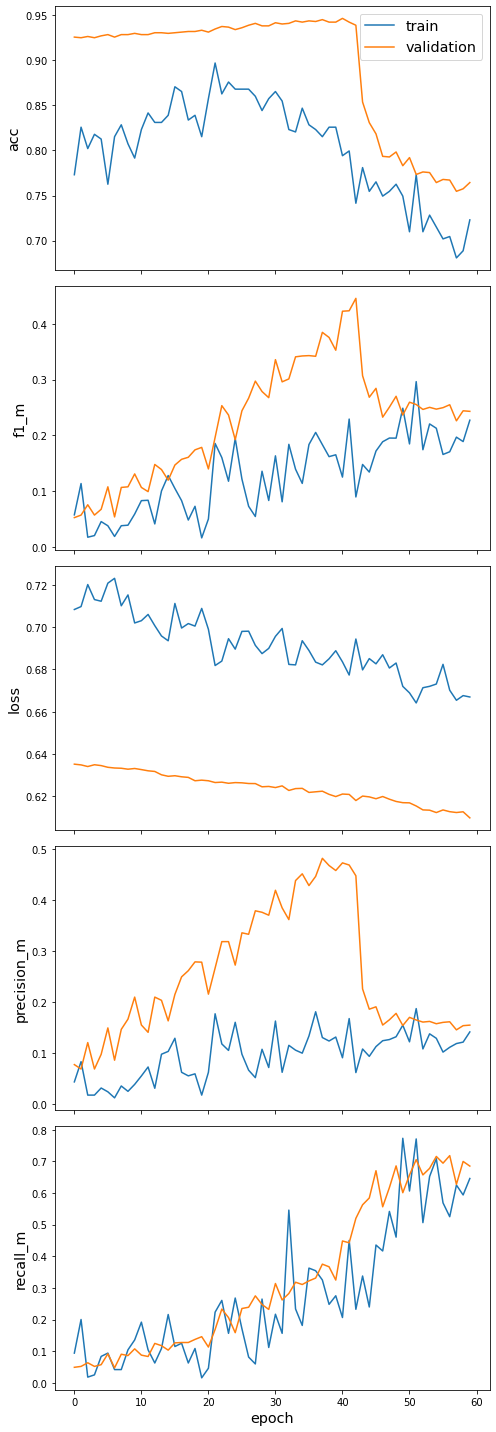

In [261]:
history2 = model2.fit(
    train_gen, epochs=60, validation_data=val_gen, verbose=0, shuffle=False, class_weight=weights
)

sg.utils.plot_history(history2)

In [262]:
# Evaluating on the test set
test_gen = generator.flow(test_labels.index, test_targets)

test_metrics = model2.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model2.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

116/116 [==============================] - 3s 23ms/step - loss: 0.6160 - acc: 0.7183 - f1_m: 0.2148 - precision_m: 0.1354 - recall_m: 0.6608

Test Set Metrics:
	loss: 0.6160
	acc: 0.7183
	f1_m: 0.2148
	precision_m: 0.1354
	recall_m: 0.6608


### 5. Making predictions with the model

Using the trained model to predict the nodes we put aside earlier. For this, we must use the original StellarGraph object and a new node generator.

In [89]:
generator = GraphSAGENodeGenerator(twitch_graph, batch_size, num_samples)

In [90]:
# Predictions for all nodes in the hold out set
hold_out_nodes = twitch_partner.index.difference(labels_sampled.index)
labels_hold_out = twitch_partner[hold_out_nodes]

In [91]:
len(hold_out_nodes)

1900

In [92]:
hold_out_gen = generator.flow(hold_out_nodes, labels_hold_out)

In [93]:
hold_out_predictions = model.predict(hold_out_gen)

In [94]:
len(hold_out_predictions)

1900

In [95]:
# Convert sigmoid predictions to binary labels
new_hold_out_predictions = []

for i, predicted in enumerate(hold_out_predictions):
    if predicted[0] > 0.5: # if probability is >0.5, then it belongs to class 1 (since binary classific.)
        new_hold_out_predictions.append(1)
    else:
        new_hold_out_predictions.append(0)

In [96]:
# Calculate accuracy the "old way"

correct_pred = 0
for i, val in enumerate(new_hold_out_predictions):
    if val == np.array(labels_hold_out)[i]:
        correct_pred += 1
        
correct_pred / len(new_hold_out_predictions)

0.9210526315789473

In [97]:
results = pd.Series(new_hold_out_predictions, index=hold_out_nodes)
df = pd.DataFrame({"Predicted": results, "True": labels_hold_out})
df.head(10)

Predicted  True
id                 
14          0     0
36          0     0
43          0     0
49          0     0
53          0     0
56          0     0
61          0     0
64          1     0
67          1     0
68          0     0

In [98]:
hold_out_metrics = model.evaluate(hold_out_gen)
print("\nHold Out Set Metrics:")
for name, val in zip(model.metrics_names, hold_out_metrics):
    print("\t{}: {:0.4f}".format(name, val))

38/38 [==============================] - 1s 24ms/step - loss: 0.2729 - acc: 0.9216 - f1_m: 0.5875 - precision_m: 0.4785 - recall_m: 0.8459

Hold Out Set Metrics:
	loss: 0.2729
	acc: 0.9216
	f1_m: 0.5875
	precision_m: 0.4785
	recall_m: 0.8459


### Node embeddings

In [99]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [100]:
emb = embedding_model.predict(hold_out_gen)
emb.shape

(1900, 32)

In [87]:
labels_hold_out

id
14      0
36      0
43      0
49      0
53      0
       ..
9479    0
9482    0
9490    0
9492    0
9495    0
Name: partner, Length: 1900, dtype: int32

Project the embeddings to 2D using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [103]:
X = emb
target_encoding = preprocessing.LabelBinarizer()
y = np.argmax(target_encoding.fit_transform(labels_hold_out), axis=1)

In [107]:
X.shape[1]

32

In [108]:
X.shape

(1900, 32)

In [104]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=hold_out_nodes)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=hold_out_nodes)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

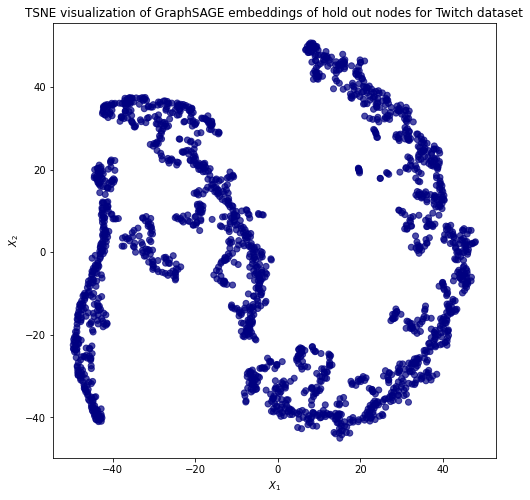

In [106]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings of hold out nodes for Twitch dataset".format(
        transform.__name__
    )
)
plt.show()

## GCN

### 1. Creating layers

In [273]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from tensorflow.keras.callbacks import EarlyStopping

In [274]:
generator = FullBatchNodeGenerator(graph_sampled, method="gcn")

Using GCN (local pooling) filters...


In [275]:
train_gen = generator.flow(train_labels.index, train_targets)

In [276]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["sigmoid", "sigmoid"], generator=generator, dropout=0.5
)

In [277]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [278]:
predictions = layers.Dense(units=1, activation="sigmoid")(x_out) #sigmoid is used in binary classification

### 2. Training and evaluating the model

In [279]:
#getting f1 score

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [280]:
model3 = Model(inputs=x_inp, outputs=predictions)
model3.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=['acc',f1_m,precision_m, recall_m],
)

C:\Users\lisannal\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [281]:
model3.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(1, 7598, 3)]       0           []                               
                                                                                                  
 input_42 (InputLayer)          [(1, None, 2)]       0           []                               
                                                                                                  
 input_43 (InputLayer)          [(1, None)]          0           []                               
                                                                                                  
 dropout_78 (Dropout)           (1, 7598, 3)         0           ['input_40[0][0]']               
                                                                                           

In [282]:
val_gen = generator.flow(val_labels.index, val_targets)
es_callback = EarlyStopping(monitor="f1_m", patience=50, restore_best_weights=True)

In [283]:
# Dealing with class imbalance
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(val_targets),
                                            y=val_targets)
#weights = {i:w for i,w in enumerate(weights)}
weights = dict(enumerate(weights))
weights

{0: 0.5316875460574797, 1: 8.38953488372093}

In [284]:
history = model3.fit(
    train_gen,
    epochs=100,
    batch_size=32,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
    #class_weight=weights
)

Epoch 1/100
1/1 - 2s - loss: 0.3650 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3355 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/100
1/1 - 0s - loss: 0.3366 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3131 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 93ms/epoch - 93ms/step
Epoch 3/100
1/1 - 0s - loss: 0.3148 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2965 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 94ms/epoch - 94ms/step
Epoch 4/100
1/1 - 0s - loss: 0.2975 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2821 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 

Epoch 33/100
1/1 - 0s - loss: 0.2045 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.1998 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 105ms/epoch - 105ms/step
Epoch 34/100
1/1 - 0s - loss: 0.2026 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.1989 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 129ms/epoch - 129ms/step
Epoch 35/100
1/1 - 0s - loss: 0.2030 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.1979 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 135ms/epoch - 135ms/step
Epoch 36/100
1/1 - 0s - loss: 0.2021 - acc: 0.9393 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.1969 - val_acc: 0.9404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - 

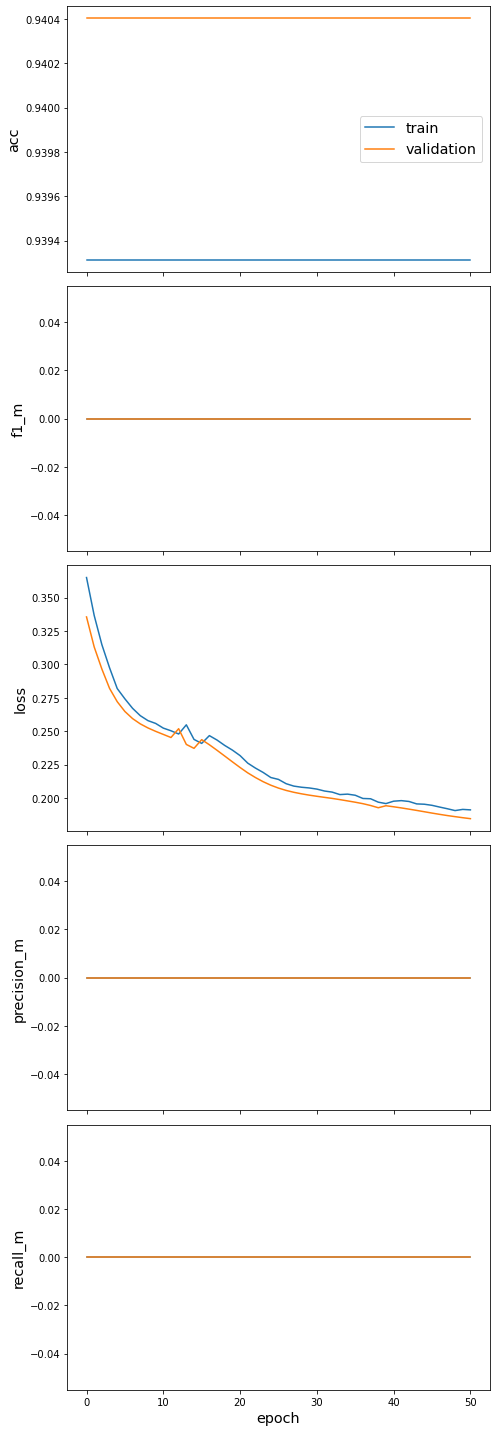

In [285]:
sg.utils.plot_history(history)

In [286]:
test_gen = generator.flow(test_labels.index, test_targets)

In [287]:
test_metrics = model3.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model3.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 61ms/step - loss: 0.3349 - acc: 0.9403 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

Test Set Metrics:
	loss: 0.3349
	acc: 0.9403
	f1_m: 0.0000
	precision_m: 0.0000
	recall_m: 0.0000


## XGB classification model

We are trying to predict weather the streamer is parnered or not

In [56]:
nodes2

days  mature     views  partner
id                                   
5079  2149       1    162078        0
4281  1574       1      1370        0
992   1034       1      6043        0
9021  1319       1     94298        1
330   2137       1      2323        0
...    ...     ...       ...      ...
4572   895       1       128        0
6355  2001       0        44        0
206   1784       1      2038        0
7695  2114       0       449        0
4451  1680       0  10638954        1

[9498 rows x 4 columns]

In [57]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(nodes2.loc[:, nodes2.columns != 'partner'], nodes2['partner'], random_state=0, train_size=0.75)

Let not deal with class imbalance to set baseline

In [58]:
%%time
import xgboost as xgb

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=8, base_score=0.5,
                        objective='binary:logistic', random_state=99)
xgc.fit(X_train, y_train)
predictions = xgc.predict(X_test)

Wall time: 1.82 s


In [59]:
import model_evaluation_utils as meu
class_labels = list(set(nodes2['partner']))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.9705
Precision: 0.9718
Recall: 0.9705
F1 Score: 0.9711

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2232
           1       0.74      0.80      0.77       143

    accuracy                           0.97      2375
   macro avg       0.86      0.89      0.87      2375
weighted avg       0.97      0.97      0.97      2375



In [60]:
# Testing if class weights make an impact

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

xgc2 = xgb.XGBClassifier(n_estimators=500, max_depth=8, base_score=0.5,
                        objective='binary:logistic', random_state=99)

xgc2.fit(X_train, y_train, sample_weight= sample_weights)
predictions2 = xgc2.predict(X_test)

import model_evaluation_utils as meu
class_labels = list(set(nodes2['partner']))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions2, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.9659
Precision: 0.9694
Recall: 0.9659
F1 Score: 0.9673

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2232
           1       0.68      0.81      0.74       143

    accuracy                           0.97      2375
   macro avg       0.84      0.89      0.86      2375
weighted avg       0.97      0.97      0.97      2375



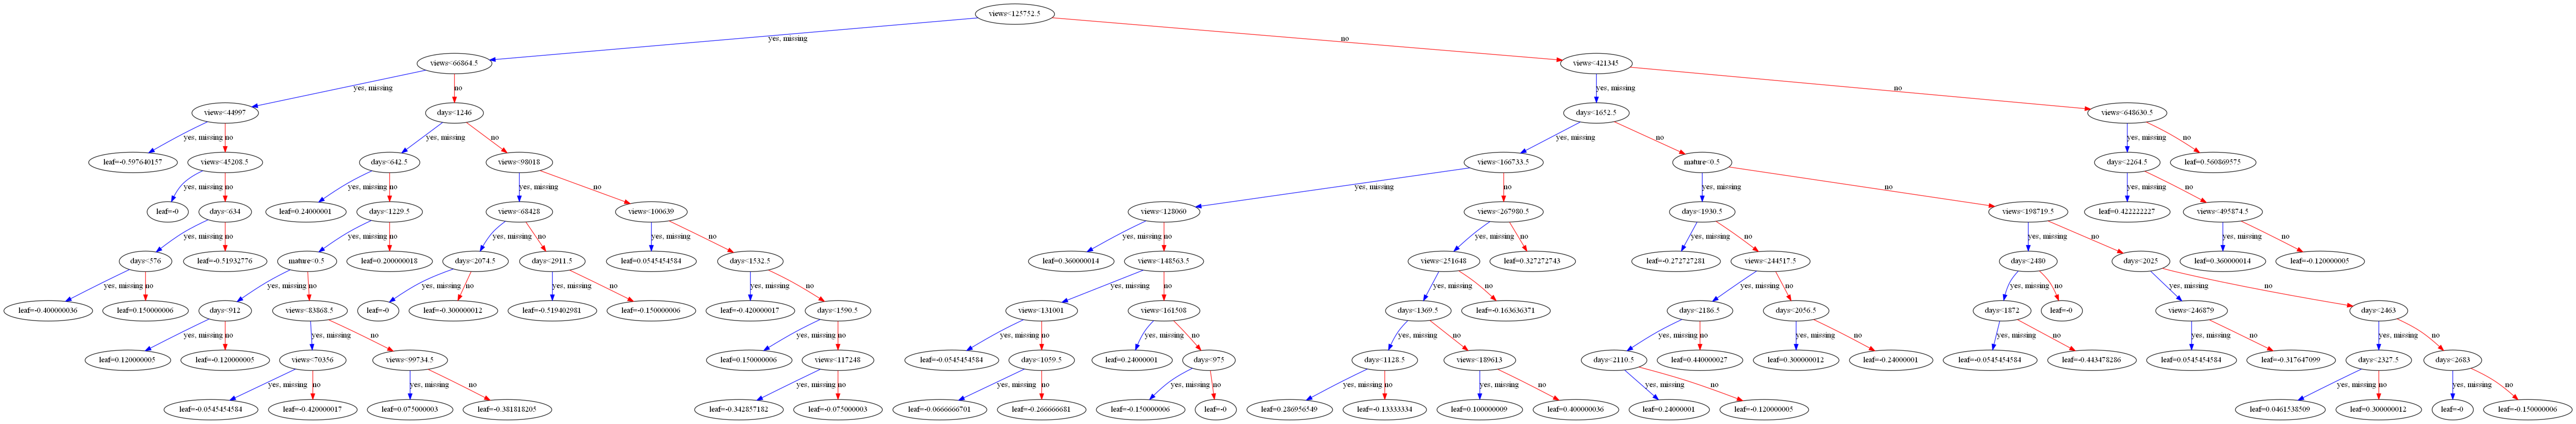

In [75]:
import matplotlib.pyplot as plt
import os
import graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

xgb.plot_tree(xgc,num_trees=0)
plt.rcParams['figure.figsize'] = [400, 400]
#plt.savefig("xgb_tree.jpg") #save as jpg
plt.show()

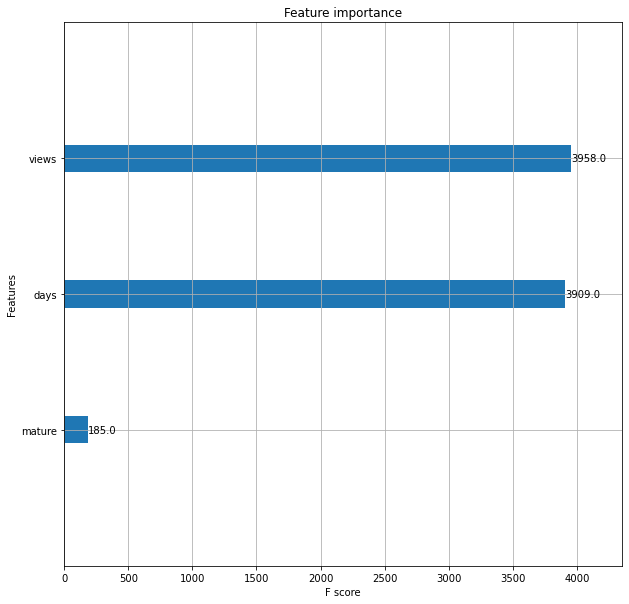

In [80]:
xgb.plot_importance(xgc)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## 5. Network visualization